In [129]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================
import plot_data as pt
import scipy_optimizer as sp_opt

In [130]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1)])
H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

$$
H = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [131]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(3)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """
    Calculates the dephasing factor as a function of the time parameter tau.

    Args:
        tau (float): A time parameter influencing the dephasing.

    Returns:
        float: The calculated dephasing factor.
    """
    return 1 - pnp.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [132]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    tau_1 = Paras_global[1]
    tau_2 = Paras_global[2]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    
    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1])

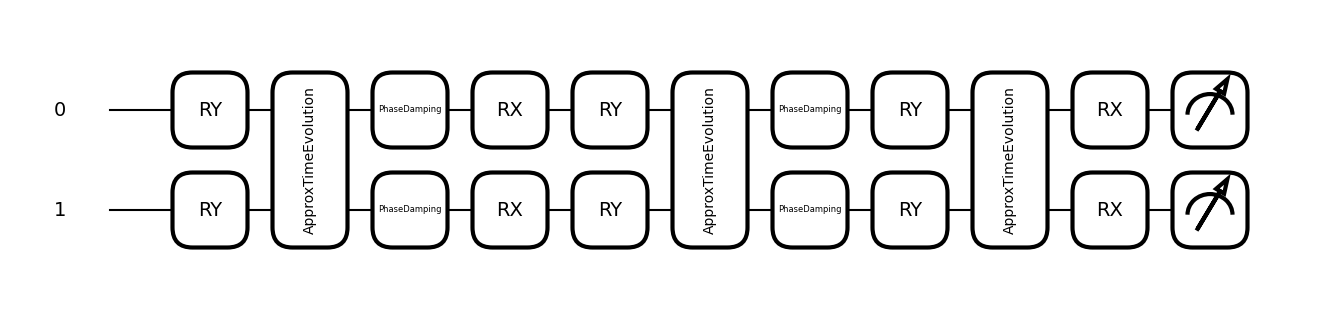

In [133]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [134]:
sweep_range = np.array([0.0, 3*np.pi, 1e-1])
Paras_global = pnp.array([2.3562155, np.pi/2, np.pi/2])
tau_dephase = 0

PHI = np.arange(sweep_range[0],sweep_range[1],sweep_range[2])
Data = np.zeros((len(PHI), 2))
Data[:,0] = PHI

for idx, phi_cur in enumerate(PHI):
    phi_temp = pnp.array([phi_cur])
    Data[idx][1] = qml.qinfo.classical_fisher(circuit)(phi_temp)
    
Data

array([[0.00000000e+00, 1.31134223e-18],
       [1.00000000e-01, 3.99999982e+00],
       [2.00000000e-01, 3.99999996e+00],
       [3.00000000e-01, 3.99999998e+00],
       [4.00000000e-01, 3.99999999e+00],
       [5.00000000e-01, 3.99999999e+00],
       [6.00000000e-01, 3.99999999e+00],
       [7.00000000e-01, 4.00000000e+00],
       [8.00000000e-01, 4.00000000e+00],
       [9.00000000e-01, 4.00000000e+00],
       [1.00000000e+00, 4.00000000e+00],
       [1.10000000e+00, 4.00000000e+00],
       [1.20000000e+00, 4.00000000e+00],
       [1.30000000e+00, 4.00000000e+00],
       [1.40000000e+00, 4.00000000e+00],
       [1.50000000e+00, 4.00000000e+00],
       [1.60000000e+00, 4.00000000e+00],
       [1.70000000e+00, 4.00000000e+00],
       [1.80000000e+00, 4.00000000e+00],
       [1.90000000e+00, 4.00000000e+00],
       [2.00000000e+00, 4.00000000e+00],
       [2.10000000e+00, 4.00000000e+00],
       [2.20000000e+00, 4.00000000e+00],
       [2.30000000e+00, 4.00000000e+00],
       [2.400000

In [135]:
phi = np.pi/2
circuit(phi)

tensor([[ 5.00000000e-01+5.55111512e-17j,
         -3.47638754e-15-2.77555756e-17j,
         -3.46250975e-15-1.38777878e-16j,
         -5.00000000e-01-2.10098076e-05j],
        [-3.43128473e-15+0.00000000e+00j,
          2.47024623e-15+2.08166817e-17j,
         -1.11022302e-16+5.20417043e-18j,
          3.50067282e-15+6.93889390e-17j],
        [-3.45903946e-15+1.38777878e-17j,
         -6.93889390e-17-5.20417043e-18j,
          2.52575738e-15-2.08166817e-17j,
          3.54230703e-15+5.55111512e-17j],
        [-5.00000000e-01+2.10098076e-05j,
          3.49026533e-15+5.55111512e-17j,
          3.50414312e-15+5.55111512e-17j,
          5.00000000e-01-5.55111512e-17j]], requires_grad=True)

In [136]:
# @qml.qnode(dev)
# def Post_selection(phi):
#     """
#     Applies post-selection to the output of the circuit function using a Kraus operator. 
#     It returns the updated density matrix.

#     Args:
#         phi (float): A phase parameter for the quantum circuit.

#     Returns:
#         array: The post-selected density matrix of the qubit.
#     """
#     global Paras_global, Gamma_ps_global
#     get_density_matrix = circuit(phi)
        
#     # Kraus operator for 2*2 matrix
#     K = pnp.array([
#         [pnp.sqrt(1 - Gamma_ps_global), 0],
#         [0, 1]
#     ])

#     Numerator = pnp.kron(K, pnp.eye(2)) @ get_density_matrix @ pnp.kron(K, pnp.eye(2)).conj().T
#     Denominator = pnp.trace(Numerator)
#     rho_ps = Numerator / Denominator

#     qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
#     return qml.density_matrix(wires = [0, 1]) 

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac{(K \otimes I) \rho (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes I) \rho (K^{\dagger} \otimes I ^{\dagger})]}
$$

In [137]:
@qml.qnode(dev)
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.tensor([
        [pnp.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ])
    
    Numerator = pnp.kron(K, K) @ get_density_matrix @ pnp.kron(K, K).conj().T
    Denominator = pnp.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K \otimes K)^{\dagger}}
% (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes K) \rho (K \otimes K)^{\dagger}]}
$$

In [138]:
sweep_range = np.array([0.0, 3*np.pi, 1e-1])
Paras_global = pnp.array([2.3562155, np.pi/2, np.pi/2])
tau_dephase = 0
Gamma_ps_global = 0.8

PHI = np.arange(sweep_range[0],sweep_range[1],sweep_range[2])
Data = np.zeros((len(PHI), 2))
Data[:,0] = PHI

for idx, phi_cur in enumerate(PHI):
    phi_temp = pnp.array([phi_cur])
    Data[idx][1] = qml.qinfo.classical_fisher(Post_selection)(phi_temp)
    
Data

array([[0.00000000e+00, 6.35167720e-18],
       [1.00000000e-01, 1.00760761e+01],
       [2.00000000e-01, 9.20117440e+00],
       [3.00000000e-01, 8.00623305e+00],
       [4.00000000e-01, 6.73513695e+00],
       [5.00000000e-01, 5.55923089e+00],
       [6.00000000e-01, 4.56051604e+00],
       [7.00000000e-01, 3.75589095e+00],
       [8.00000000e-01, 3.12815795e+00],
       [9.00000000e-01, 2.64807626e+00],
       [1.00000000e+00, 2.28604743e+00],
       [1.10000000e+00, 2.01685755e+00],
       [1.20000000e+00, 1.82082597e+00],
       [1.30000000e+00, 1.68345673e+00],
       [1.40000000e+00, 1.59465632e+00],
       [1.50000000e+00, 1.54798004e+00],
       [1.60000000e+00, 1.54007722e+00],
       [1.70000000e+00, 1.57038353e+00],
       [1.80000000e+00, 1.64106794e+00],
       [1.90000000e+00, 1.75723460e+00],
       [2.00000000e+00, 1.92737731e+00],
       [2.10000000e+00, 2.16406132e+00],
       [2.20000000e+00, 2.48472794e+00],
       [2.30000000e+00, 2.91230926e+00],
       [2.400000

In [139]:
phi = np.pi/2
Post_selection(phi)

array([[ 3.84615385e-02+8.21170876e-18j, -5.97956835e-16-4.77410414e-18j,
        -5.95569783e-16-2.38705207e-17j, -1.92307692e-01-8.08069525e-06j],
       [-5.90198916e-16-6.04848393e-32j,  9.50094704e-16+8.00641604e-18j,
        -4.27008856e-17+2.00160401e-18j,  3.01067015e-15+5.96763018e-17j],
       [-5.94972874e-16+2.38705207e-18j, -2.66880535e-17-2.00160401e-18j,
         9.71445147e-16-8.00641604e-18j,  3.04647666e-15+4.77410414e-17j],
       [-1.92307692e-01+8.08069525e-06j,  3.00171944e-15+4.77410414e-17j,
         3.01365470e-15+4.77410414e-17j,  9.61538462e-01-8.21170876e-18j]])

In [140]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Sets global parameters for dephasing time and gamma post-selection.

    Args:
        desired_tau_dephase (float): The desired dephasing time.
        desired_gamma_post_selection (float): The gamma value for post-selection.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [141]:
def cost_function(paras):
    """
    Defines the cost function for optimization, which is the negative of the 
    Classical Fisher Information (CFI).

    Args:
        paras (array): Parameters to optimize.

    Returns:
        float: The negative value of the CFI for the given parameters.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI